In [1]:
from torch.utils.data import TensorDataset, DataLoader
import gymnasium as gym
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
import seaborn as sns
from Models.actor import *
from Models.world import *
from stable_baselines3 import PPO

/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/shimmy/registration.py", line 303, in register_gymnasium_envs
    _register_dm_control_envs()
  File "/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/shimmy/registration.py", line 63, in _register_dm_control_envs
    from shimmy.dm_control_compatibility import DmControlCompatibilityV0
  File "/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/shimmy/dm_control_compatibility.py", line 16, in <module>
    from dm_control import composer
  File "/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/dm_control/composer/__init__.py

In [2]:
device = 'cpu'

In [15]:
world_network  = torch.load('world_network.pth',map_location='cpu',weights_only=False)
actor_network  = torch.load('actor_network.pth',map_location='cpu',weights_only=False)


In [4]:

# Creat dataset
def generate_experience(actor,env,device,NUM_EPISODES = 1000,MAX_STEPS = 100):

    inputs = torch.zeros(NUM_EPISODES, 6)
    labels = torch.zeros(NUM_EPISODES, MAX_STEPS, 7)
    for episode in range(NUM_EPISODES):
        # Initialize new actor
    
        # Reset environment
        state = env.reset()
        # Reshape state variable
        state = torch.tensor(np.concatenate([state[0]['observation'], state[0]['desired_goal']])).float()
        inputs[episode, :] = state
    
        for step in range(MAX_STEPS):
            action = actor(state.to(device))
            # Take step in environment to get new state and reward
            new_state, reward, _, _, _ = env.step(action.detach().cpu())
            new_state = torch.tensor(np.concatenate([new_state['observation'], new_state['desired_goal']])).float()
    
            # Add data 
            labels[episode, step, :] = torch.hstack([state, torch.tensor(reward).float()])
    
            # Set current state to new state
            state = new_state.clone()
            
    inputs = inputs.to(device)
    labels = labels.to(device)
    return inputs, labels

In [5]:
def plot_reward_model(world_network,actor_network,env,num_episodes,max_steps):
    '''
    Plot the predicted reward for each state visited by actor in env
    :param world_network: World model 
    :param actor_network: Actor model
    :param env: Environment
    :return: Plot of predicted reward for each state
    '''
    inputs,labels = generate_experience(actor_network,env,'cpu',num_episodes,max_steps)
    outputs = world_network.forward(inputs)
    rows = []
    for episode in range(outputs.shape[0]):
        for t in range(outputs.shape[1]):
            rows.append({'episode':episode,
                         't':t,
                         'x': labels[episode,t,0].item(),
                         'y': labels[episode,t,1].item(),
                         'reward': outputs[episode,t,-1].item(),})
            
    df = pd.DataFrame(rows)
    sns.scatterplot(x='x',y='y',hue='reward',data=df,legend=False,alpha=.5)

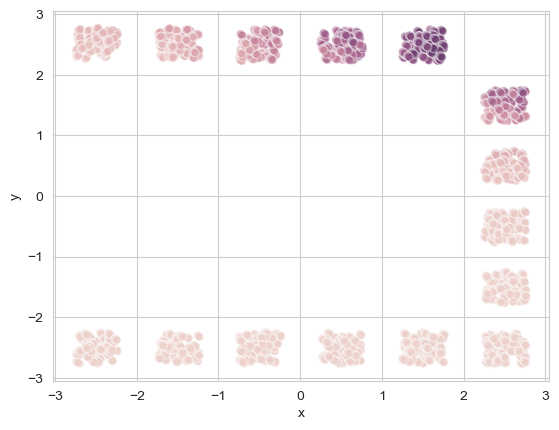

In [7]:
MEDIUM_MAZE = [
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 'g', 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1]]
env = gym.make('PointMaze_Medium-v3',
               max_episode_steps=100,maze_map= MEDIUM_MAZE,
               render_mode = 'rgb_array'
)
world_network.N_STEPS = 5
world_network.device = 'cpu'
plot_reward_model(world_network,actor_network,env,num_episodes = 1000,max_steps = 5)

In [16]:
# PLOT 2D TRAJECTORIES (REAL OR SIMULATED) IN ENVIRONMENT
def plot_model_trajectories(world_network,actor_network,env,num_episodes =1000,max_steps = 100):
    inputs,labels = generate_experience(actor_network,env,'cpu',num_episodes,max_steps)
    outputs = world_network.forward(inputs)
    rows = []
    for episode in range(outputs.shape[0]):
        for t in range(outputs.shape[1]):
            rows.append({'episode':episode,
                         't':t,
                         'x': outputs[episode,t,0].item(),
                         'y': outputs[episode,t,1].item(),})
            
    df = pd.DataFrame(rows)
    sns.scatterplot(x='x',y='y',hue='t',data=df,legend=False,alpha=.5)

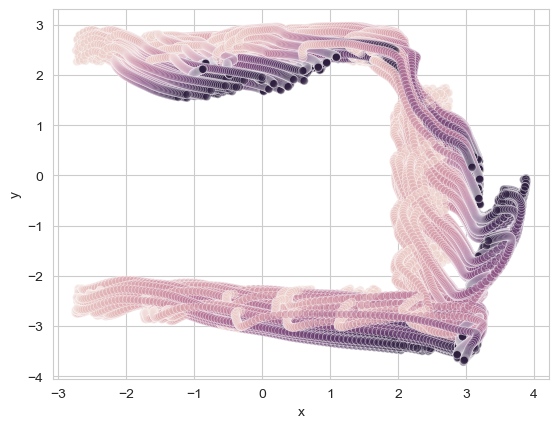

In [18]:
world_network.N_STEPS = 100
world_network.device = 'cpu'
plot_model_trajectories(world_network,actor_network,env,num_episodes =1000,max_steps = 100)

In [19]:
# SIMULATE ACTOR
def simulate_actor(actor_network,env,NUM_EPISODES=25,MAX_STEPS=100):
    for episode in range(NUM_EPISODES):
        
        if episode % 100==0:
            print(episode)
    
        
        # Imagined trajectory
        state = env.reset()
        state = torch.tensor(np.concatenate([state[0]['observation'], state[0]['desired_goal']])).float()
        #state = init_state
        for step in range(MAX_STEPS):
            env.render()
            action = actor_network(state)
            new_state, reward, _, _,_ = env.step(action.detach())
            state = torch.tensor(np.concatenate([new_state['observation'],new_state['desired_goal']])).float()
            #print(reward)
    env.close()



0


2025-04-21 16:10:04.510 python[10960:2285715] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-21 16:10:04.510 python[10960:2285715] +[IMKInputSession subclass]: chose IMKInputSession_Modern


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


KeyboardInterrupt: 

In [ ]:
MEDIUM_MAZE = [
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1]]

# Initialize environment with this map for training.
env = gym.make('PointMaze_Medium-v3',
               max_episode_steps=100,maze_map= MEDIUM_MAZE,
               render_mode = 'human'
)

simulate_actor(actor_network,env,NUM_EPISODES=25,MAX_STEPS=100)
